In [1]:
!python --version

Python 3.5.3 :: Continuum Analytics, Inc.


In [2]:
!conda env list

# conda environments:
#
astroconda            *  /home/Jerome/miniconda3/envs/astroconda
iraf27                   /home/Jerome/miniconda3/envs/iraf27
ircs_pol                 /home/Jerome/miniconda3/envs/ircs_pol
moscatel                 /home/Jerome/miniconda3/envs/moscatel
py27                     /home/Jerome/miniconda3/envs/py27
root                     /home/Jerome/miniconda3



# Dipper (sub-)list

The links below show the quick look lightcurve reduced using a K2 data pipeline called [K2SFF](https://archive.stsci.edu/prepds/k2sff/) available online.

* [EPIC204514548](https://www.cfa.harvard.edu/~avanderb/k2c2/ep204514548.html)
* [EPIC203384911](https://www.cfa.harvard.edu/~avanderb/k2c2/ep203843911.html)
* [EPIC203937317](https://www.cfa.harvard.edu/~avanderb/k2c2/ep203937317.html)
* [EPIC204630363](https://www.cfa.harvard.edu/~avanderb/k2c2/ep204630363.html)
* [* EPIC204638512](https://www.cfa.harvard.edu/~avanderb/k2c2/ep204638512.html)
* [* EPIC205151387](https://www.cfa.harvard.edu/~avanderb/k2c2/ep205151387.html)
* [EPIC203824153](https://www.cfa.harvard.edu/~avanderb/k2c2/ep203824153.html)
* [* EPIC204278916](https://www.cfa.harvard.edu/~avanderb/k2c2/ep204278916.html)
* [EPIC204469637](https://www.cfa.harvard.edu/~avanderb/k2c2/ep204469637.html)

## Corrected lightcurves from Vanderburg website

* [campaign 2](https://www.cfa.harvard.edu/~avanderb/k2c2/)

The advantage of this approach over using everest-pipeline is that direct download of corrected lightcurve is possible, making analysis relatively quickly. Take caution however that the pipeline might remove inherent variability in the dipper lightcurve so study how the pipeline exactly does the correction. 

In [3]:
epics='''204638512
205151387
204514548
203843911
203937317
204630363
203824153
204278916
204469637'''.split('\n')

## Download all

* DF is a dictionary of dataframes of downloaded raw Vanderburg light curves
* DF2 has the time (BJD) as index
* DF3 has outliers and NaNs removed

In [5]:
import pandas as pd

campaign=str(2)
part1='http://archive.stsci.edu/missions/hlsp/k2sff/c0'
part2='00000/'
part3='/hlsp_k2sff_k2_lightcurve_'
part4='_kepler_v1_llc-default-aper.txt'


DF = {}
for epic in epics:
    try:
        url=part1+campaign+'/'+epic[:4]+part2+epic[-5:]+part3+epic+'-c0'+campaign+part4
        print('downloading: {}'.format(epic))
        #save in dict
        DF[epic] = pd.read_csv(url, sep=",", header=0, index_col=False)
        #save locally as csv
        #fname=epic+'_lc_vanderburg.csv'
        #DF[epic].to_csv(fname)
    except Exception as e:
        print('{0}: {1}'.format(epic, e))

downloading: 204638512
downloading: 205151387
downloading: 204514548
downloading: 203843911
downloading: 203937317
downloading: 204630363
downloading: 203824153
downloading: 204278916
downloading: 204469637


In [6]:
DF.keys()

dict_keys(['204469637', '203843911', '203824153', '204630363', '205151387', '204638512', '204278916', '204514548', '203937317'])

setting date as index

In [7]:
DF2 = {}
for key in DF.keys():
    DF2[key] = DF[key].set_index(keys=DF[key].columns[0])
    DF2[key].columns = [key]

In [19]:
#from astropy.stats import sigma_clip
import numpy as np
from scipy import stats

#filtered lightcurve dicts
DF3={}

#remove outliers within 3 sigma and drop nans
for key in DF2.keys():
    DF3[key] = DF2[key][(np.abs(stats.zscore(DF2[key])) < 5).all(axis=1)]
    DF3[key] = DF3[key].dropna()
    print('Dropped NaNs: {}'.format(len(DF3[key].dropna())))

Dropped NaNs: 3280
Dropped NaNs: 3241
Dropped NaNs: 3307
Dropped NaNs: 3241
Dropped NaNs: 3210
Dropped NaNs: 3261
Dropped NaNs: 3278
Dropped NaNs: 3225
Dropped NaNs: 3250


Plot comparison of raw and filtered light curves

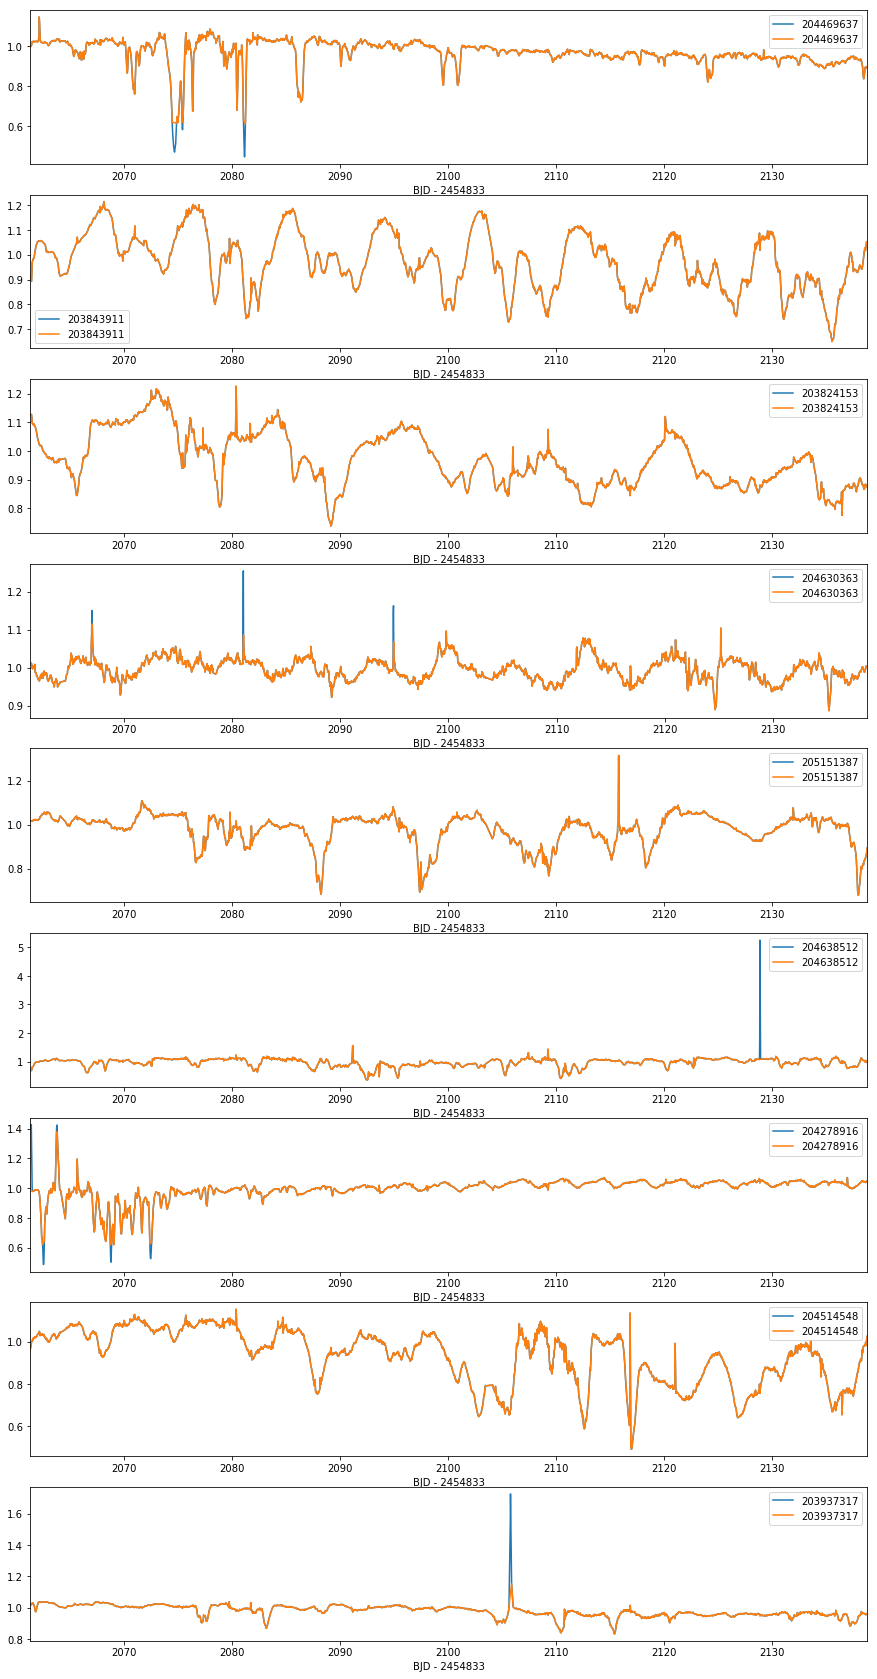

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(nrows=len(DF3.keys()),ncols=1, figsize=(15,30))
for i,j in enumerate(DF3.keys()):
    DF2[str(j)].dropna().plot(ax=ax[i], legend=True, label='original')
    DF3[str(j)].dropna().plot(ax=ax[i], legend=True, label='outliers removed')
    #ax[i].set_title(j)

## Gaussian Processes

[doc](http://scikit-learn.org/stable/modules/gaussian_process.html)

### Gaussian Process Regression (GPR)

For this, the prior of the GP needs to be specified. The prior mean is assumed to be constant and zero (for normalize_y=False) or the training data’s mean (for normalize_y=True). The prior’s covariance is specified by a passing a kernel object. The hyperparameters of the kernel are optimized during fitting of GaussianProcessRegressor by maximizing the log-marginal-likelihood (LML) based on the passed optimizer. As the LML may have multiple local optima, the optimizer can be started repeatedly by specifying n_restarts_optimizer. The first run is always conducted starting from the initial hyperparameter values of the kernel; subsequent runs are conducted from hyperparameter values that have been chosen randomly from the range of allowed values. If the initial hyperparameters should be kept fixed, None can be passed as optimizer.

The noise level in the targets can be specified by passing it via the parameter alpha, either globally as a scalar or per datapoint. Note that a moderate noise level can also be helpful for dealing with numeric issues during fitting as it is effectively implemented as Tikhonov regularization, i.e., by adding it to the diagonal of the kernel matrix. An alternative to specifying the noise level explicitly is to include a WhiteKernel component into the kernel, which can estimate the global noise level from the data (see example below).

Run gp on all light curves

/home/Jerome/miniconda3/envs/astroconda/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'nit': 11, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 75, 'grad': array([ -1.51416810e-05,   2.80791542e-04])}
  " state: %s" % convergence_dict)


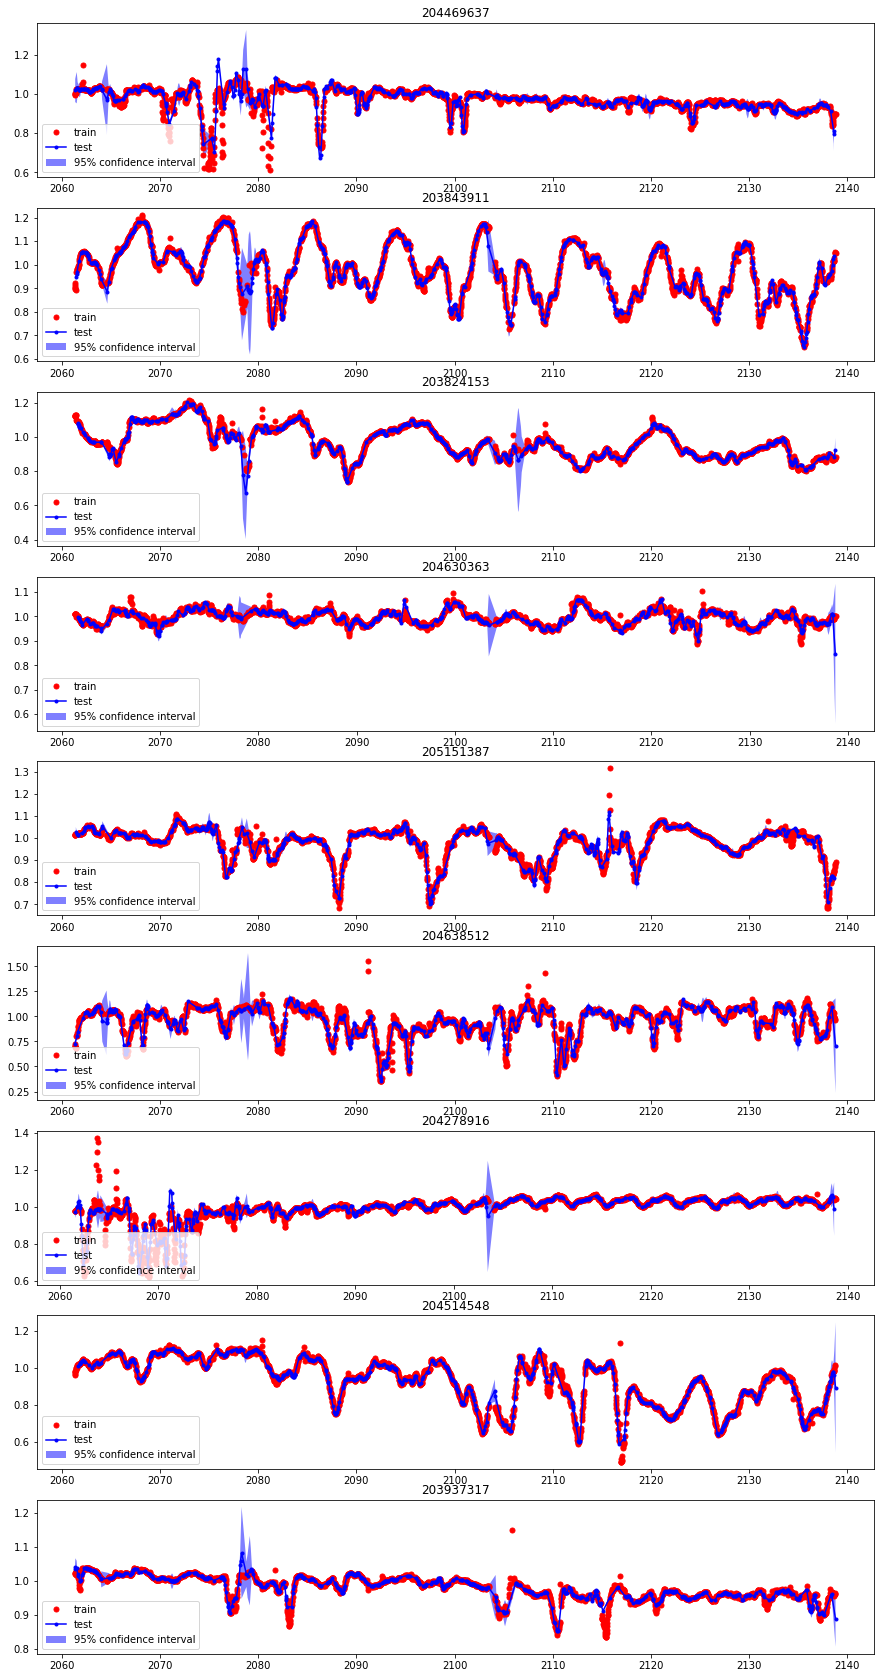

In [38]:
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import numpy as np

# Instanciate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))

gp = gaussian_process.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

fig, ax = plt.subplots(nrows=len(DF3.keys()),ncols=1, figsize=(15,30))
for i, key in enumerate(DF3.keys()):
    #split data
    mask = np.random.rand(len(DF3[key])) < 0.8
    train = DF3[key][mask]
    test = DF3[key][~mask]
    
    X_train = train.index.values.reshape(-1,1)
    y_train = train[key].values

    X_test = test.index.values.reshape(-1,1)
    y_test = test[key].values
    
    #use small subset only for fitting
    gp.fit(X_train[::10],y_train[::10])
    
    #use all test dataset for predicting
    gp_pred, sigma=gp.predict(X_test, return_std=True)
    
    #plot
    ax[i].plot(X_train, y_train, 'r.', markersize=10, label=u'train')
    ax[i].plot(X_test, gp_pred, 'b.-', label=u'test')
    ax[i].fill(np.concatenate([X_test, X_test[::-1]]),
             np.concatenate([gp_pred - 1.9600 * sigma,
                            (gp_pred + 1.9600 * sigma)[::-1]]),
             alpha=.5, fc='b', ec='None', label='95% confidence interval')
    ax[i].set_title(key)
    ax[i].legend(loc='lower left')

## Random Forest Regressor

Run rf on all light curves

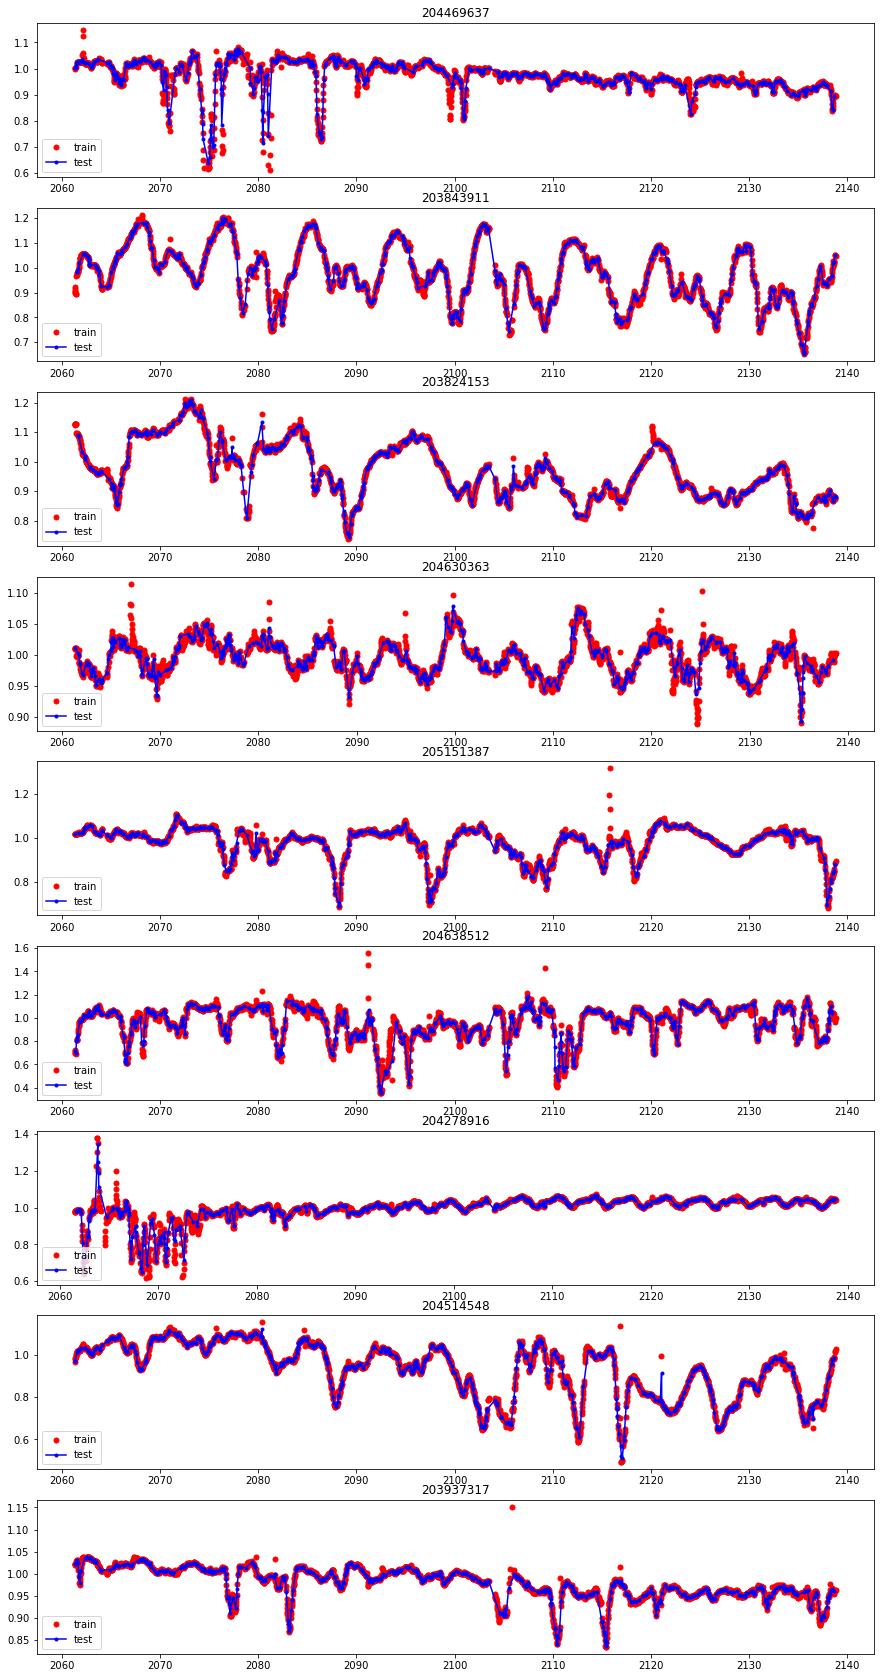

In [37]:
from sklearn import ensemble
import numpy as np

rf = ensemble.RandomForestRegressor(random_state=0, n_estimators=100)

fig, ax = plt.subplots(nrows=len(DF3.keys()),ncols=1, figsize=(15,30))
for i, key in enumerate(DF3.keys()):
    #split data
    mask = np.random.rand(len(DF3[key])) < 0.8
    train = DF3[key][mask]
    test = DF3[key][~mask]
    
    X_train = train.index.values.reshape(-1,1)
    y_train = train[key].values

    X_test = test.index.values.reshape(-1,1)
    y_test = test[key].values
    
    #use small ALL data for fitting
    rf.fit(X_train,y_train)
    
    #use all test dataset for predicting
    rf_pred = rf.predict(X_test)
    
    #plot
    ax[i].plot(X_train, y_train, 'r.', markersize=10, label=u'train')
    ax[i].plot(X_test, rf_pred, 'b.-', label=u'test')
    ax[i].set_title(key)
    ax[i].legend(loc='lower left')

## Summary

* RF uses all training data while GP uses only a fraction
* RF fits the light curve better than GP qualitatively
* RF runs faster than GP